In [1]:
# Importar bibliotecas necessárias para análise e modelagem
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_log_error, make_scorer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from haversine import haversine

In [2]:
# Carregar os conjuntos de dados de treino e teste
treino_df = pd.read_csv('train.csv')
teste_df = pd.read_csv('test.csv')

In [3]:
# Exibir resumo do DataFrame de treino (treino_df)
treino_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [4]:
# Exibir resumo do DataFrame de teste (teste_df)
teste_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 625134 entries, 0 to 625133
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  625134 non-null  object 
 1   vendor_id           625134 non-null  int64  
 2   pickup_datetime     625134 non-null  object 
 3   passenger_count     625134 non-null  int64  
 4   pickup_longitude    625134 non-null  float64
 5   pickup_latitude     625134 non-null  float64
 6   dropoff_longitude   625134 non-null  float64
 7   dropoff_latitude    625134 non-null  float64
 8   store_and_fwd_flag  625134 non-null  object 
dtypes: float64(4), int64(2), object(3)
memory usage: 42.9+ MB


In [5]:
# Definir uma função para calcular a distância Haversine entre dois pontos geográficos
def haversine_distancia(linha):
    inicio = (linha['pickup_latitude'], linha['pickup_longitude'])
    fim = (linha['dropoff_latitude'], linha['dropoff_longitude'])
    return haversine(inicio, fim)

# Definir uma função para categorizar a hora do dia
def categorizar_hora(hora):
    if 0 <= hora < 6:
        return 'madrugada'
    elif 6 <= hora < 12:
        return 'manhã'
    elif 12 <= hora < 18:
        return 'tarde'
    else:
        return 'noite'

# Função principal para pré-processamento dos dados
def pre_processo_dados(df, is_train=True):
    # Converter a coluna de data e hora para datetime e extrair características
    df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])
    df['pickup_hour'] = df['pickup_datetime'].dt.hour
    df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
    df['pickup_month'] = df['pickup_datetime'].dt.month
    
    # Calcular a distância Haversine para cada viagem
    df['distance'] = df.apply(haversine_distancia, axis=1)
    
    # Criar uma nova feature com base no período do dia
    df['periodo_dia'] = df['pickup_hour'].apply(categorizar_hora)
    
    # Codificar variáveis categóricas em variáveis dummy
    df = pd.get_dummies(df, columns=['periodo_dia'], drop_first=True)
    
    # Definir as colunas que não serão usadas para modelagem e devem ser removidas
    colunas = ['id', 'vendor_id', 'store_and_fwd_flag', 'pickup_datetime']
    if is_train and 'dropoff_datetime' in df.columns:
        colunas.append('dropoff_datetime')
    df = df.drop(columns=colunas)
    
    return df

In [6]:
# Processar os dados de treino e teste
treino_df = pre_processo_dados(treino_df, is_train=True)
teste_df = pre_processo_dados(teste_df, is_train=False)

# Definir o número de clusters para K-Means
n_clusters = 10

# Aplicar K-Means para o pickup
kmeans_pickup = KMeans(n_clusters=n_clusters, random_state=42)
treino_df['pickup_cluster'] = kmeans_pickup.fit_predict(treino_df[['pickup_latitude', 'pickup_longitude']])
teste_df['pickup_cluster'] = kmeans_pickup.predict(teste_df[['pickup_latitude', 'pickup_longitude']])

# Aplicar K-Means para o dropoff
kmeans_dropoff = KMeans(n_clusters=n_clusters, random_state=42)
treino_df['dropoff_cluster'] = kmeans_dropoff.fit_predict(treino_df[['dropoff_latitude', 'dropoff_longitude']])
teste_df['dropoff_cluster'] = kmeans_dropoff.predict(teste_df[['dropoff_latitude', 'dropoff_longitude']])

# Remover outliers baseados na distância e duração
treino_df = treino_df[(treino_df['distance'] > 0) & (treino_df['trip_duration'] > 0)]
treino_df = treino_df[treino_df['trip_duration'] < treino_df['trip_duration'].quantile(0.99)]

# Transformação logarítmica da variável alvo
treino_df['log_trip_duration'] = np.log1p(treino_df['trip_duration'])

# Separar as variáveis dependentes e independentes
X = treino_df.drop(columns=['trip_duration', 'log_trip_duration'])
y = treino_df['log_trip_duration']

# Dividir os dados de treino para validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Criar o pipeline para XGBRegressor
pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('model', XGBRegressor(objective='reg:squarederror', random_state=42))
])

# Definir os hiperparâmetros para o Grid Search do XGBRegressor
param_grid_xgb = {
    'model__n_estimators': [100, 300],
    'model__max_depth': [10, 15],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.8, 1],
    'model__colsample_bytree': [0.8, 1]
}

# Definir o scorer RMSLE para o GridSearchCV
rmsle_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_log_error(y_true, y_pred)), greater_is_better=False)

# Configurar o Grid Search para o XGBRegressor usando RMSLE
grid_search_xgb = GridSearchCV(pipeline_xgb, param_grid_xgb, cv=3, scoring=rmsle_scorer, n_jobs=-1)

# Treinar o modelo XGBRegressor
grid_search_xgb.fit(X_train, y_train)

# Melhor combinação de hiperparâmetros
print(f"Melhores hiperparâmetros para XGBRegressor: {grid_search_xgb.best_params_}")

# Prever no conjunto de validação
y_pred_log_xgb = grid_search_xgb.predict(X_val)
y_pred_xgb = np.expm1(y_pred_log_xgb)

# Reverter a transformação logarítmica de y_val
y_val_actual = np.expm1(y_val)

# Avaliar o modelo com RMSLE
rmsle_xgb = np.sqrt(mean_squared_log_error(y_val_actual, y_pred_xgb))
print(f'Root Mean Squared Logarithmic Error para XGBRegressor: {rmsle_xgb}')

# Previsões no conjunto de teste
teste_df['distance'] = teste_df['distance'].replace(0, teste_df['distance'].mean())  # Evitar divisão por zero
test_predictions_log_xgb = grid_search_xgb.predict(teste_df)
test_predictions_xgb = np.expm1(test_predictions_log_xgb)

# Salvar as previsões
output_xgb = pd.DataFrame({'id': teste_df.index, 'predicted_trip_duration': test_predictions_xgb})
output_xgb.to_csv('teste_previsao_xgboost.csv', index=False)

Melhores hiperparâmetros para XGBRegressor: {'model__colsample_bytree': 0.8, 'model__learning_rate': 0.1, 'model__max_depth': 10, 'model__n_estimators': 300, 'model__subsample': 1}
Root Mean Squared Logarithmic Error para XGBRegressor: 0.33186079033880683


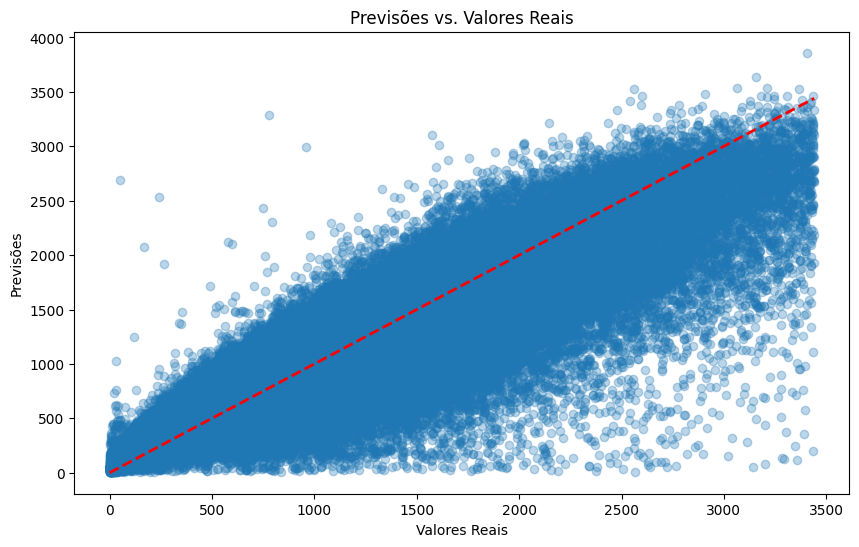

In [7]:
# Gráfico de dispersão das previsões versus valores reais
plt.figure(figsize=(10, 6))
plt.scatter(y_val_actual, y_pred_xgb, alpha=0.3)
plt.plot([0, max(y_val_actual)], [0, max(y_val_actual)], 'r--', lw=2)  # Linha de identidade
plt.xlabel('Valores Reais')
plt.ylabel('Previsões')
plt.title('Previsões vs. Valores Reais')
plt.show()

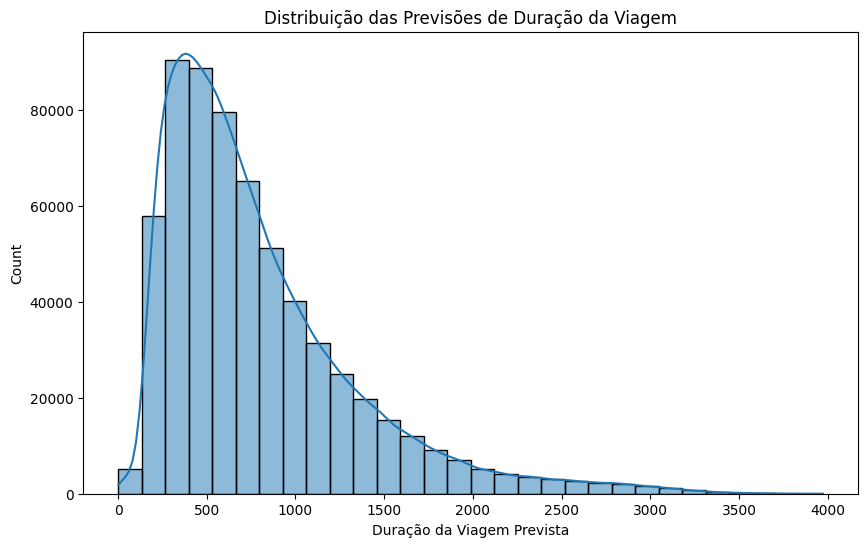

In [8]:
# Gráfico de barras das Distribuições das Previsões de Duração da Viagem
plt.figure(figsize=(10, 6))
sns.histplot(test_predictions_xgb, bins=30, kde=True)
plt.xlabel('Duração da Viagem Prevista')
plt.title('Distribuição das Previsões de Duração da Viagem')
plt.show()

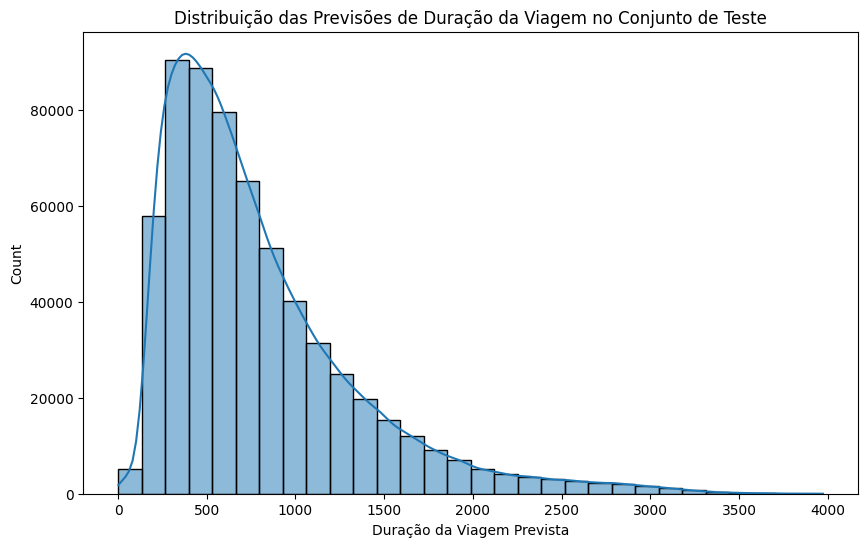

In [9]:
# Gráfico de barras das Previsões de Duração da Viagem no Conjunto de Teste
plt.figure(figsize=(10, 6))
sns.histplot(test_predictions_xgb, bins=30, kde=True)
plt.xlabel('Duração da Viagem Prevista')
plt.title('Distribuição das Previsões de Duração da Viagem no Conjunto de Teste')
plt.show()

In [10]:
# Dicionário de tradução das colunas para português
colunas = {
    'id': 'identificador',
    'vendor_id': 'id_do_vendedor',
    'pickup_datetime': 'data_hora_coleta',
    'passenger_count': 'numero_passageiros',
    'pickup_longitude': 'longitude_coleta',
    'pickup_latitude': 'latitude_coleta',
    'dropoff_longitude': 'longitude_destino',
    'dropoff_latitude': 'latitude_destino',
    'store_and_fwd_flag': 'indicador_armazenar_encaminhar',
    'predicted_trip_duration': 'duracao_viagem_prevista_(min)'
    }

# Carregar os datasets de teste e das previsões feitas pelo modelo
tabela_teste = pd.read_csv('test.csv')
tabela_resultado = pd.read_csv('teste_previsao_xgboost.csv')

# Converter a duração prevista das viagens de segundos para minutos e arredondar para o inteiro mais próximo
tabela_resultado['predicted_trip_duration'] = (tabela_resultado['predicted_trip_duration']/60).round(0)

# Combinar o dataset de teste original com as previsões das durações das viagens
tabela = pd.concat([tabela_teste, tabela_resultado['predicted_trip_duration']], axis=1)

# Renomear as colunas do dataset combinado para português, utilizando o dicionário de tradução
tabela = tabela.rename(columns=colunas)

# Exibir o dataframe resultante com as colunas traduzidas e as previsões
display(tabela)

,identificador,id_do_vendedor,data_hora_coleta,numero_passageiros,longitude_coleta,latitude_coleta,longitude_destino,latitude_destino,indicador_armazenar_encaminhar,duracao_viagem_prevista_(min)
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N,14.0
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N,9.0
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N,7.0
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N,17.0
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N,7.0
...,...,...,...,...,...,...,...,...,...,...
625129,id3008929,1,2016-01-01 00:02:52,1,-74.003464,40.725105,-74.001251,40.733643,N,4.0
625130,id3700764,1,2016-01-01 00:01:52,1,-74.006363,40.743782,-73.953407,40.782467,N,20.0
625131,id2568735,1,2016-01-01 00:01:24,2,-73.972267,40.759865,-73.876602,40.748665,N,28.0
625132,id1384355,1,2016-01-01 00:00:28,1,-73.976501,40.733562,-73.854263,40.891788,N,32.0
